In [32]:
import pandas as pd
from collections import Counter
import re
import numpy as np
import matplotlib.pyplot as plt 
# Load the dataset
data = pd.read_csv('../data/cad_v1_1_parents.csv')

# Display the first few rows to understand its structure
#data.head()

C:\Users\fapay\AppData\Local\Temp\ipykernel_26804\543874620.py:7: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/cad_v1_1_parents.csv')


### 1- Basic Overview

In [5]:
# Calculate number of threads
num_threads = len(data)

# Calculate distribution of primary annotations
annotation_distribution = data['annotation_Primary'].value_counts(normalize=True) * 100

# Check for missing values
missing_values = data.isnull().sum()

num_threads, annotation_distribution

(27494,
 Neutral                     79.781043
 IdentityDirectedAbuse        9.925802
 AffiliationDirectedAbuse     4.906525
 PersonDirectedAbuse          4.044519
 CounterSpeech                0.800175
 Slur                         0.541936
 Name: annotation_Primary, dtype: float64)

In [27]:
# Calculate the total number of comments
total_comments = len(data)

# Calculate the distribution of comments across datasets
dataset_distribution = data["split"].value_counts()
dataset_percentages = data["split"].value_counts(normalize=True) * 100

# Create a DataFrame for the dataset distribution 
dataset_table = pd.DataFrame({
    "Dataset": dataset_distribution.index,
    "Total Comments": dataset_distribution.values,
    "Percentage": dataset_percentages.values
})

# Calculate the distribution of primary annotations for each dataset
primary_annotation_distribution = data.groupby(["split", "annotation_Primary"]).size().unstack(fill_value=0)
primary_annotation_percentages = primary_annotation_distribution.div(primary_annotation_distribution.sum(axis=1), axis=0) * 100

# Print the results
print(f"Total number of comments: {total_comments}")
print("\nDistribution of comments across datasets:")
print(dataset_table)
print("\nDistribution of primary annotations for each dataset:")
print(primary_annotation_distribution)
print("\nPercentage distribution of primary annotations for each dataset:")
print(primary_annotation_percentages)

Total number of comments: 27494

Distribution of comments across datasets:
         Dataset  Total Comments  Percentage
0          train           14113   51.331200
1           test            5495   19.986179
2            dev            4684   17.036444
3  exclude_empty            2244    8.161781
4    exclude_bot             604    2.196843
5   exclude_lang             353    1.283916
6  exclude_image               1    0.003637

Distribution of primary annotations for each dataset:
annotation_Primary  AffiliationDirectedAbuse  CounterSpeech  \
split                                                         
dev                                      271             38   
exclude_bot                               30              3   
exclude_empty                             22              0   
exclude_image                              0              0   
exclude_lang                               0              0   
test                                     258             66   
train 

### 2- Thread and Parent Relationships:
- What is the average number of comments in a thread?
- What's the distribution of the number of parents for each post?

In [7]:
# Calculate the average number of comments in a thread
# I will do this by counting non-null values in the `parent_text_level_X` columns where X is the level
num_comments_per_thread = data.filter(like='parent_text_level_').notnull().sum(axis=1).mean()

# Calculate distribution of number of parents for each post
# Assuming that each non-null entry in `parent_text_level_X` columns where X>0 represents a parent
num_parents_distribution = data.filter(like='parent_text_level_').iloc[:, 1:].notnull().sum(axis=1).value_counts(normalize=True) * 100

num_comments_per_thread, num_parents_distribution

(1.9713392012802793,
 0     46.893868
 1     23.532407
 2     15.792537
 3      7.314323
 4      3.498945
 5      2.331418
 6      0.229141
 7      0.127301
 8      0.094566
 9      0.058195
 10     0.054557
 11     0.043646
 12     0.014549
 13     0.014549
 dtype: float64)

### 3- Length Analysis
- What's the average, median, minimum, and maximum length (in terms of words) of posts?
- What's the average, median, minimum, and maximum length of parent posts?

In [10]:
# Calculate length of posts in terms of words using the correct column
post_lengths = data['meta_text'].str.split().str.len()

# Calculate length of parent posts in terms of words (using the first parent as a representative)
parent_lengths = data['parent_text_level_0'].str.split().str.len()

post_length_stats = {
    "Average": post_lengths.mean(),
    "Median": post_lengths.median(),
    "Minimum": post_lengths.min(),
    "Maximum": post_lengths.max()
}

parent_length_stats = {
    "Average": parent_lengths.mean(),
    "Median": parent_lengths.median(),
    "Minimum": parent_lengths.min(),
    "Maximum": parent_lengths.max()
}
# Calculate combined length of posts and their parent comments in terms of words
combined_lengths = data.filter(like='meta_text').apply(lambda row: ' '.join(row.dropna()), axis=1).str.split().str.len()

combined_length_stats = {
    "Average": combined_lengths.mean(),
    "Median": combined_lengths.median(),
    "Minimum": combined_lengths.min(),
    "Maximum": combined_lengths.max()
}


post_length_stats, parent_length_stats, combined_length_stats

({'Average': 30.954422879714382,
  'Median': 14.0,
  'Minimum': 1.0,
  'Maximum': 1855.0},
 {'Average': 27.004714872170062,
  'Median': 14.0,
  'Minimum': 1.0,
  'Maximum': 1854.0},
 {'Average': 29.64279479159089, 'Median': 13.0, 'Minimum': 0, 'Maximum': 1855})

80th percentile: 118.0
90th percentile: 185.0
95th percentile: 260.0

Mean: 81.27315050556486
Median: 47.0
Standard deviation: 121.01427230904636

% Below length:
256 tokens: 94.80%
512 tokens: 98.87%
1024 tokens: 99.76%


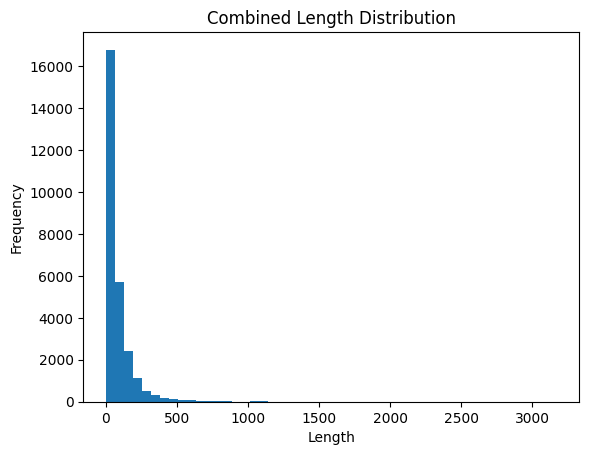

In [33]:
# Combine all relevant text fields
text_fields = ['meta_text'] + [f'parent_text_level_{i}' for i in range(7)]
combined_texts = data[text_fields].fillna('').apply(lambda x: ' '.join(x), axis=1)

# Calculate the length of combined texts
combined_lengths = combined_texts.str.split().str.len()

# Percentiles
p80 = np.percentile(combined_lengths, 80)
p90 = np.percentile(combined_lengths, 90)
p95 = np.percentile(combined_lengths, 95)
print(f"80th percentile: {p80}")
print(f"90th percentile: {p90}")
print(f"95th percentile: {p95}")

# Statistics
print(f"\nMean: {combined_lengths.mean()}")
print(f"Median: {combined_lengths.median()}")
print(f"Standard deviation: {combined_lengths.std()}")

# Histogram
plt.hist(combined_lengths, bins=50)
plt.title("Combined Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.savefig("combined_hist.png")

# Threshold percentages  
print("\n% Below length:")
print(f"256 tokens: {sum(combined_lengths < 256)/len(combined_lengths) * 100:.2f}%")
print(f"512 tokens: {sum(combined_lengths < 512)/len(combined_lengths) * 100:.2f}%") 
print(f"1024 tokens: {sum(combined_lengths < 1024)/len(combined_lengths) * 100:.2f}%")

In [16]:
combined_lengths

0          0
1        307
2          0
3          0
4          0
        ... 
27489      8
27490      2
27491     15
27492     35
27493      3
Length: 27494, dtype: int64

### 4. Temporal Analysis:

In [17]:
#the code has been written with instruction following here https://pandas.pydata.org/docs/reference/series.html
# Extract timestamp for each post
data['meta_date'] = pd.to_datetime(data['meta_date'], errors='coerce')

# Extract year, month, day, and hour from the timestamp
data['year'] = data['meta_date'].dt.year
data['month'] = data['meta_date'].dt.month
data['day'] = data['meta_date'].dt.day
data['hour'] = data['meta_date'].dt.hour

# Determine hate speech prevalence over time
hate_speech_labels = ["IdentityDirectedAbuse", "AffiliationDirectedAbuse", "PersonDirectedAbuse", "Slur"]
data['is_hate_speech'] = data['annotation_Primary'].isin(hate_speech_labels)

monthly_distribution = data.groupby('month')['is_hate_speech'].mean()
hourly_distribution = data.groupby('hour')['is_hate_speech'].mean()

monthly_distribution, hourly_distribution

(month
 2    0.196316
 3    0.181240
 4    0.165216
 5    0.180004
 6    0.240754
 7    0.228816
 Name: is_hate_speech, dtype: float64,
 hour
 0     0.147844
 1     0.176303
 2     0.186864
 3     0.200000
 4     0.191161
 5     0.184489
 6     0.208549
 7     0.200267
 8     0.180352
 9     0.197037
 10    0.203463
 11    0.222892
 12    0.199794
 13    0.180851
 14    0.213773
 15    0.185933
 16    0.197101
 17    0.212780
 18    0.193311
 19    0.211756
 20    0.210215
 21    0.196497
 22    0.203229
 23    0.205833
 Name: is_hate_speech, dtype: float64)

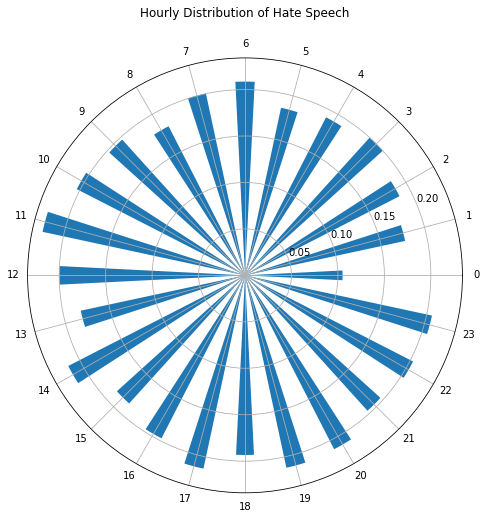

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# Create circular axes
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(polar=True)) 

# Set theta values around the circle 
theta = np.arange(0, 2*np.pi, 2*np.pi/len(hourly_distribution))

# Plot bars along theta
ax.bar(theta, hourly_distribution.values, width=0.1, bottom=0.0)

# Set ticks and labels
ax.set_xticks(theta)
ax.set_xticklabels(hourly_distribution.index)

# Add title and rotate labels
ax.set_title("Hourly Distribution of Hate Speech", y=1.08)
plt.xticks(rotation=45)

plt.savefig("hourly_hate_speech_polar.png")
plt.show()

In [18]:
# Convert the 'meta_date' column to a datetime format
data['created_datetime'] = pd.to_datetime(data['meta_date'])

# Extract the week from the datetime
data['week'] = data['created_datetime'].dt.strftime('%Y-%U')

# Group data by week and calculate the frequency of each hate speech category
weekly_trends = data.groupby(['week', 'annotation_Primary']).size().unstack().fillna(0)

# Filtering out the "Neutral" and "CounterSpeech" categories for clarity in visualization
weekly_trends = weekly_trends.drop(columns=['Neutral', 'CounterSpeech'], errors='ignore')

weekly_trends


annotation_Primary,AffiliationDirectedAbuse,IdentityDirectedAbuse,PersonDirectedAbuse,Slur
week,,,,
2019-04,4.0,57.0,8.0,1.0
2019-05,43.0,115.0,43.0,7.0
2019-06,40.0,102.0,58.0,4.0
2019-07,46.0,113.0,48.0,5.0
2019-08,32.0,84.0,54.0,7.0
2019-09,24.0,76.0,35.0,4.0
2019-10,51.0,126.0,92.0,11.0
2019-11,21.0,62.0,45.0,3.0
2019-12,92.0,110.0,40.0,12.0


C:\Users\fapay\AppData\Local\Temp\ipykernel_18392\2457088950.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['created_datetime'] = pd.to_datetime(data['meta_date'])


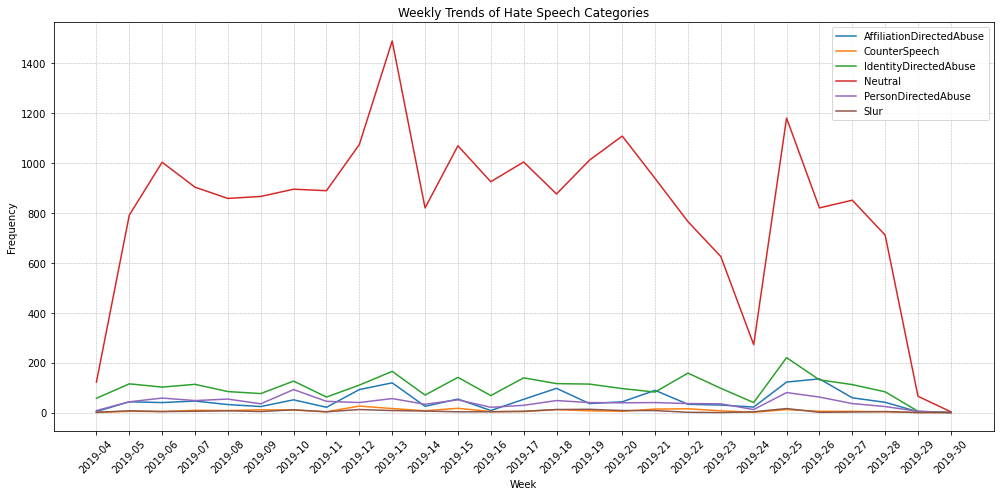

In [71]:
# Convert date to datetime 
data['created_datetime'] = pd.to_datetime(data['meta_date'])

# Filter data to only specified collection period
start_date = '2019-02-01'  
end_date = '2019-07-31'

data = data[(data['created_datetime'] >= start_date) & 
            (data['created_datetime'] <= end_date)]

# Extract week and group by week 
data['week'] = data['created_datetime'].dt.strftime('%Y-%U') 
weekly_trends = data.groupby(['week', 'annotation_Primary']).size().unstack().fillna(0)

plt.figure(figsize=(14, 7))
for category in weekly_trends.columns:
    plt.plot(weekly_trends.index, weekly_trends[category], label=category)
    
plt.title("Weekly Trends of Hate Speech Categories")
plt.xlabel("Week")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [73]:
weekly_trends

annotation_Primary,AffiliationDirectedAbuse,CounterSpeech,IdentityDirectedAbuse,Neutral,PersonDirectedAbuse,Slur
week,,,,,,
2019-04,4.0,0.0,57.0,122.0,8.0,1.0
2019-05,43.0,5.0,115.0,791.0,43.0,7.0
2019-06,40.0,4.0,102.0,1003.0,58.0,4.0
2019-07,46.0,9.0,113.0,903.0,48.0,5.0
2019-08,32.0,8.0,84.0,858.0,54.0,7.0
2019-09,24.0,11.0,76.0,866.0,35.0,4.0
2019-10,51.0,10.0,126.0,895.0,92.0,11.0
2019-11,21.0,3.0,62.0,889.0,45.0,3.0
2019-12,92.0,26.0,110.0,1074.0,40.0,12.0


### 5. User Analysis


In [19]:
# Calculate number of unique users
unique_users = data['meta_author'].nunique()

# Identify users more likely to be involved in hate speech threads
user_hate_speech_distribution = data.groupby('meta_author')['is_hate_speech'].mean().sort_values(ascending=False)

# Calculate correlation between user activity and likelihood of posting hate speech
user_activity = data['meta_author'].value_counts()
user_activity_hate_speech_corr = user_activity.corr(user_hate_speech_distribution)

unique_users, user_activity_hate_speech_corr

(11123, 0.010309200482633441)

Skew: 1.773451581342257
Number of users above 0.5: 1475


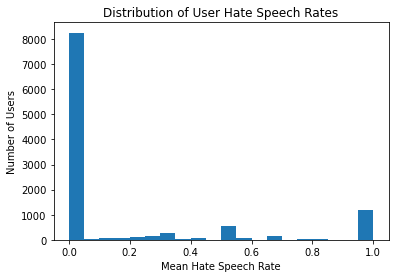

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# Existing code to get user hate speech distribution 
user_hate_speech_dist = data.groupby('meta_author')['is_hate_speech'].mean().sort_values(ascending=False)

# Plot distribution
plt.figure()
user_hate_speech_dist.plot.hist(bins=20)
plt.title("Distribution of User Hate Speech Rates")
plt.xlabel("Mean Hate Speech Rate")
plt.ylabel("Number of Users")

# Quantify skew
print("Skew:", user_hate_speech_dist.skew())

# Identify threshold for "high" hate speech users 
threshold = 0.5 # for example
print("Number of users above {}: {}".format(threshold, (user_hate_speech_dist > threshold).sum()))

In [20]:
user_hate_speech_dist = data.groupby('meta_author')['is_hate_speech'].mean().sort_values(ascending=False) 

print(user_hate_speech_dist)

meta_author
KnownBeaner             1.0
Razorwire_Dave          1.0
Kaquin                  1.0
Karmawasforsuckers      1.0
ComplimentaryFood       1.0
                       ... 
PM_ME_A_FACT            0.0
PM_ME_CUTE_PUPPYS       0.0
PM_ME_FUTA_AND_TACOS    0.0
PM_ME_HAIRLESS_CATS     0.0
zyklorpthehuman         0.0
Name: is_hate_speech, Length: 11123, dtype: float64


In [21]:
print("Skew:", user_hate_speech_dist.skew())
print("Number above 0.5:", (user_hate_speech_dist > 0.5).sum())

Skew: 1.773451581342257
Number above 0.5: 1475


### 6. Content Analysis

In [22]:
# Tokenize text
def tokenize(text):
    return re.findall(r'\w+', text.lower())

# Extract content from hate speech and non-hate speech threads
hate_speech_content = ' '.join(data[data['is_hate_speech']]['meta_text'].dropna())
non_hate_speech_content = ' '.join(data[~data['is_hate_speech']]['meta_text'].dropna())

# Tokenize and count words
hate_speech_words = Counter(tokenize(hate_speech_content))
non_hate_speech_words = Counter(tokenize(non_hate_speech_content))


# List of common English stop words
stop_words = set([
"ourselves", "hers", "between", "yourself", "but", "again", "there", "about", "once", "during", "out", 
    "very", "having", "with", "they", "own", "an", "be", "some", "for", "do", "its", "yours", "such", "into",
    "of", "most", "itself", "other", "off", "is", "s", "am", "or", "who", "as", "from", "him", "each",
    "the", "themselves", "until", "below", "are", "we", "these", "your", "his", "through", "don", "nor", "me", "were", "her", "more", "himself", "this", "down", "should", "our", "their", "while", "above", "both", "up", "to", "ours", "had", "she", "all", "no", "when", "at", "any", "before", "them", "same", "and", "been", "have", "in", "will", "on", "does", "yourselves", "then", "that", "because", "what", "over", "why", "so", "can", "did", "not", "now", "under", "he", "you", "herself", "has", "just", "where", "too", "only", "myself", "which", "those", "i", "after", "few", "whom", "t", "being", "if", "theirs", "my", "against", "a", "by", "doing", "it", "how", "further", "was", "here", "than", "linebreak","https","re", "r", "com", "linebreak", "www", "reddit", "would", "get",
    "people", "like", "archive", "one", "think", "even", "m", "know", "right", "want", "say", "make",
    "also", "comments", "org", "time", "never", "see", "go", "us", "really","much", "world",
    "good", "removed", "message", "ve", "way","something", "still", "i", "you", "we", "they", "me", "him", "her", "it",
    "a", "the", "and", "to", "of", "in", "for", "on", "at", "with", "by", "as",
    "just", "that", "from", "this", "but", "what", "so", "like", 'going','doesn', 'd',
    '1', 'could', 'let', 'didn', 'got', 'someone', 'post', 'comment', 'thing', 'subreddit', 
    'd', 'deleted','isn'])

# Tokenize text and remove stop words
def tokenize_without_stopwords(text):
    return [word for word in re.findall(r'\w+', text.lower()) if word not in stop_words]

# Tokenize and count words without stop words
hate_speech_words_no_stopwords = Counter(tokenize_without_stopwords(hate_speech_content))
non_hate_speech_words_no_stopwords = Counter(tokenize_without_stopwords(non_hate_speech_content))

# Get the most common words in hate speech and non-hate speech threads without stop words
top_hate_speech_words_no_stopwords = hate_speech_words_no_stopwords.most_common(50)
top_non_hate_speech_words_no_stopwords = non_hate_speech_words_no_stopwords.most_common(50)

top_hate_speech_words_no_stopwords, top_non_hate_speech_words_no_stopwords

([('fucking', 633),
  ('shit', 463),
  ('fuck', 445),
  ('white', 376),
  ('women', 350),
  ('left', 283),
  ('men', 271),
  ('look', 253),
  ('actually', 251),
  ('well', 247),
  ('trump', 232),
  ('hate', 229),
  ('need', 222),
  ('black', 219),
  ('retarded', 213),
  ('sub', 211),
  ('snapshillbot', 202),
  ('care', 201),
  ('bot', 200),
  ('far', 192),
  ('take', 191),
  ('literally', 190),
  ('megalodon', 188),
  ('jp', 188),
  ('man', 185),
  ('said', 185),
  ('every', 184),
  ('real', 182),
  ('ever', 180),
  ('life', 180),
  ('anything', 179),
  ('ll', 177),
  ('things', 176),
  ('back', 174),
  ('person', 169),
  ('racist', 169),
  ('removeddit', 169),
  ('believe', 168),
  ('everyone', 167),
  ('many', 166),
  ('contact', 164),
  ('anyone', 162),
  ('mean', 162),
  ('made', 161),
  ('years', 161),
  ('lol', 160),
  ('bad', 158),
  ('always', 156),
  ('gay', 155),
  ('compose', 155)],
 [('shit', 696),
  ('bot', 682),
  ('well', 675),
  ('sub', 670),
  ('actually', 632),
  ('co

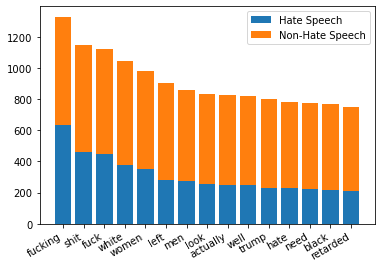

In [36]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib_venn import venn2
import re
from collections import Counter

# Sample data
hate_speech_words = [('fucking', 633), ('shit', 463), ('fuck', 445), ('white', 376), ('women', 350), ('left', 283), ('men', 271), ('look', 253), ('actually', 251), ('well', 247), ('trump', 232), ('hate', 229), ('need', 222), ('black', 219), ('retarded', 213), ('sub', 211), ('snapshillbot', 202), ('care', 201), ('bot', 200), ('far', 192), ('take', 191), ('literally', 190), ('megalodon', 188), ('jp', 188), ('man', 185), ('said', 185), ('every', 184), ('real', 182), ('ever', 180), ('life', 180), ('anything', 179), ('ll', 177), ('things', 176), ('back', 174), ('person', 169), ('racist', 169), ('removeddit', 169), ('believe', 168), ('everyone', 167), ('many', 166), ('contact', 164), ('anyone', 162), ('mean', 162), ('made', 161), ('years', 161), ('lol', 160), ('bad', 158), ('always', 156), ('gay', 155), ('compose', 155)]

non_hate_speech_words = [('shit', 696), ('bot', 682), ('well', 675), ('sub', 670), ('actually', 632), ('compose', 621), ('contact', 586), ('please', 578), ('jp', 577), ('megalodon', 574), ('things', 568), ('person', 553), ('said', 551), ('life', 547), ('need', 533), ('use', 521), ('mean', 515), ('conspiracy', 513), ('feel', 506), ('lot', 506), ('2', 497), ('first', 495), ('snapshillbot', 478), ('real', 477), ('drama', 474), ('white', 474), ('take', 473), ('every', 472), ('back', 467), ('bad', 466), ('anything', 463), ('though', 463), ('years', 462), ('ll', 461), ('pretty', 459), ('fucking', 457), ('fuck', 451), ('better', 443), ('sure', 440), ('always', 437), ('many', 435), ('point', 433), ('yeah', 428), ('made', 424), ('web', 418), ('removeddit', 418), ('look', 409), ('rules', 408), ('everyone', 403), ('anyone', 398)]

# Get top 15 words
hate_words = [word for (word, freq) in hate_speech_words[:15]]
non_hate_words = [word for (word, freq) in non_hate_speech_words[:15]]

# Bar chart
x = range(len(hate_words))
y1 = [freq for (word, freq) in hate_speech_words[:15]]
y2 = [freq for (word, freq) in non_hate_speech_words[:15]]

plt.bar(x, y1, label='Hate Speech')
plt.bar(x, y2, bottom=y1, label='Non-Hate Speech')
plt.xticks(x, hate_words, rotation=30, ha='right')
plt.legend()
plt.savefig('words_bar.png')


In [39]:

# Word cloud
wc = WordCloud(width=400, height=200)
wc.generate(" ".join(hate_words))
wc.to_file("hate_cloud.png")

# Word cloud for non-hate speech
wc2 = WordCloud(width=400, height=200) 
wc2.generate(" ".join(non_hate_words))
wc2.to_file("non_hate_cloud.png")

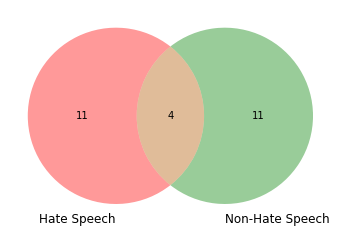

In [38]:

# Venn diagram
venn2([set(hate_words), set(non_hate_words)], set_labels=['Hate Speech', 'Non-Hate Speech'])